## Double Pendulum

$T = \frac{1}{2} (m_1+m_2)L_1^2 \dot{\phi_1}^2 + m_2 L_1 L_2 \dot{\phi_1}\dot{\phi_2} \cos{(\phi_1 - \phi_2)} + \frac{1}{2}m_2 L_2^2 \dot{\phi_2}^2 $

$U = (m_1 + m_2)g L_1 (1-\cos{\phi_1}) + m_2 g L_2 (1-\cos{\phi_2})$

In [24]:
%matplotlib inline

import numpy as np
from scipy.integrate import odeint, solve_ivp
'''
from sympy import symbols, diff, Function, Derivative
from sympy.solvers import solve
from sympy import *
#from sympy import init_printing
from IPython.display import display
#init_printing(use_latex='mathjax')
'''''
import matplotlib.pyplot as plt

# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

In [25]:
def sin(x):
    return np.sin(x)
def cos(x):
    return np.cos(x)

class TriplePendulum():
    """
    Pendulum class implements the parameters and differential equation for 
     a double pendulum using the notation above.
     
    Parameters
    ----------
    L1 : float
         first segment's length 
    L2 : float
        second segment's length
    m1 : float
        first bob's mass 
    m2 : float
        second bob's mass
    g : float
        value of gravitational constant 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    driving_force(t) 
        Returns the value of the external driving force at time t.
    """
    def __init__(self, LVec=[1.,1.,1.], mVec=[1.,1.,1.], g=1.):
        self.LVec = LVec
        self.mVec = mVec
        self.g=g
        
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi_1(t)  = th1
            y[1] = dphi_1/dt = z1
            y[2] = phi_2(t)  = th2
            y[3] = dphi_2/dt = z2
            y[4] = phi_3(t)  = th3
            y[5] = dphi_3/dt = z3
            
        Returns
        -------
        y_dot: float
            A 4-component vector with 
            y_dot[0] = dphi_1/dt      = z1
            y_dot[1] = d^2 phi_1/dt^2 = z1_dot
            y_dot[2] = dphi_2/dt      = z2
            y_dot[3] = d^2 phi_2/dt^2 = z2_dot 
            y_dot[4] = dphi_3/dt      = z3
            y_dot[5] = d^2 phi_3/dt^2 = z3_dot             
        
        """
        y_dot = [0. for i in range(6)]
        th1, th2, th3 = y[0], y[2], y[4]
        z1, z2, z3 = y[1], y[3], y[5]
        z1sq, z2sq, z3sq = z1**2, z2**2, z3**2

        g = self.g
        L1, L2, L3 = self.LVec
        m1, m2, m3 = self.mVec
        
        denom = m2*(2*m1+m2)+(m1+m2)*m3-m2*(m2+m3)*cos(2*(th1-th2)) \
            -m1*m3*cos(2*(th2-th3))
        
        # Do dphi_1/dt and dphi_2/dt first:
        y_dot[0] = z1
        y_dot[2] = z2
        y_dot[4] = z3
        
        # Now do d^2 phi_1/dt^2 
        y_dot[1]= -(g*(m2*(m2+m3)+m1*(2*m2+m3)-m1*m3*cos(2*(th2-th3))) \
            *sin(th1)+g*m2*(m2+m3)*sin(th1-2*th2)+2*m2*sin(th1-th2) \
            *((m2+m3)*(L1*cos(th1-th2)*z1sq+L2*z2sq)+L3*m3*cos(th2-th3) \
            *z3sq))/(L1*denom)                    
            
        # Next do d^2 phi_2/dt^2 
        y_dot[3]= (g*cos(th1)*((2*m2*(m1+m2)+(m1+2*m2)*m3)*sin(th1-th2)-m1*m3*sin(th1+th2-2*th3))
            +L1*((2*m2*(m1+m2)+(m1+2*m2)*m3)*sin(th1-th2)-m1*m3*sin(th1+th2-2*th3))*z1sq \
            +L2*(m2*(m2+m3)*sin(2*(th1-th2))-m1*m3*sin(2*(th2-th3)))*z2sq \
            +2*L3*m3*(m2*cos(th1-th3)*sin(th1-th2)-m1*sin(th2-th3))*z3sq) \
            /(L2*denom)
        
        # Finally do d^2 phi_3/dt^2
        y_dot[5]= (2*m1*sin(th2-th3)*((m2+m3)*(cos(th1-th2)*(g*cos(th1)+L1*z1sq)+L2*z2sq) \
                +L3*m3*cos(th2-th3)*z3sq))/(L3*denom)
        
        
        return y_dot
    
    
    def solve_ode(self, t_pts, y_0, abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = y_0 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        return solution.y                      


In [26]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [34]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
deltaphi_vs_time_labels = (r'$t$', r'$\Delta\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Common pendulum parameters
m_vec=[1,1,1]
L_vec=[1,1,1]
g_val = 1.


# Instantiate a pendulum 
tp1 = TriplePendulum(LVec=L_vec, mVec=m_vec, g=g_val)

[0, 0, 0, 0, 0.7853981633974483, 0] [0.001, 0, 0.001, 0, 0.7863981633974483, 0]
(10001,) (10001,) (10001,)
(10001,) (10001,)


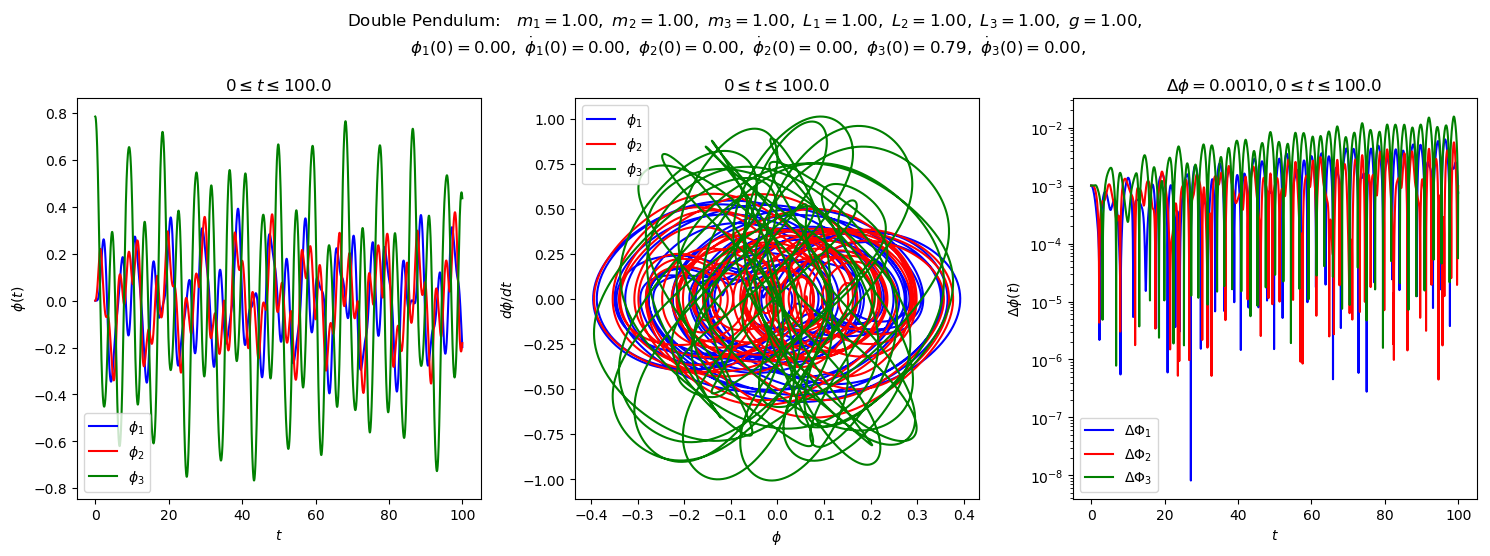

In [36]:
# both plots: same initial conditions
"""
        y_0[0] = phi_1(0)
        y_0[1] = dphi_1/dt(0) = z1
        y_0[2] = phi_2(t)(0)
        y_0[3] = dphi_2/dt(0)
        y_0[4] = phi_3(t)(0)
        y_0[5] = dphi_3/dt(0)
"""
y_0 = [0. for i in range(6)]

y_0[0] = 0
y_0[1] = 0

y_0[2] = 0
y_0[3] = 0

y_0[4] = np.pi/4.
y_0[5] = 0 

dy_0 = [y_0[i] for i in range(6)]
dPhi  = 0.001
dy_0[0] += dPhi
dy_0[2] += dPhi
dy_0[4] += dPhi
print(y_0, dy_0)

phi1, phi1_dot, phi2, phi2_dot, phi3, phi3_dot = tp1.solve_ode(t_pts, y_0)
phi1p, phi1_dotp, phi2p, phi2_dotp, phi3p, phi3_dotp = tp1.solve_ode(t_pts, dy_0)

deltaPhi1 = np.abs(phi1-phi1p)
deltaPhi2 = np.abs(phi2-phi2p)
deltaPhi3 = np.abs(phi3-phi3p)

print(t_pts.shape, phi1.shape, phi2.shape)
print(phi1_dot.shape, phi2_dot.shape)

# start the plot!
fig = plt.figure(figsize=(15,5))

overall_title = 'Double Pendulum:  ' + \
                rf' $m_1 = {m_vec[0]:.2f},$' + \
                rf' $m_2 = {m_vec[1]:.2f},$' + \
                rf' $m_3 = {m_vec[2]:.2f},$' + \
                rf' $L_1 = {L_vec[0]:.2f},$' + \
                rf' $L_2 = {L_vec[1]:.2f},$' + \
                rf' $L_3 = {L_vec[2]:.2f},$' + \
                rf' $g = {g_val:.2f},$' + '\n' +  \
                rf' $\phi_1(0) = {y_0[0]:.2f},$' + \
                rf' $\dot\phi_1(0) = {y_0[1]:.2f},$' + \
                rf' $\phi_2(0) = {y_0[2]:.2f},$' + \
                rf' $\dot\phi_2(0) = {y_0[3]:.2f},$' + \
                rf' $\phi_3(0) = {y_0[4]:.2f},$' + \
                rf' $\dot\phi_3(0) = {y_0[5]:.2f},$' +'\n'
fig.suptitle(overall_title, va='baseline')

# first plot: plot from t=0 to t=10   
ax_a = fig.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r"$\phi_1$",
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=r"$\phi_2$", 
            title=rf'$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], phi3[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='green',
            label=r"$\phi_3$", 
            title=rf'$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_a)

# second plot: state space plot from t=30 to t=50   
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, 0., t_end)    
plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label=r"$\phi_1$",  
            ax=ax_b)    
plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='red',
            label=r"$\phi_2$", 
            title=rf'$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_b)
plot_y_vs_x(phi2[start : stop], phi3_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='green',
            label=r"$\phi_3$", 
            title=rf'$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_b)

# third plot: delta phi plot
ax_a = fig.add_subplot(1,3, 3)                  

start, stop = start_stop_indices(t_pts, 0., t_end)    
plot_y_vs_x(t_pts[start : stop], deltaPhi1[start : stop], 
            axis_labels=deltaphi_vs_time_labels, 
            color='blue',
            label=rf'$\Delta\Phi_1$', 
            semilogy=True,
            ax=ax_a)
plot_y_vs_x(t_pts[start : stop], deltaPhi2[start : stop], 
            axis_labels=deltaphi_vs_time_labels, 
            color='red',
            label=rf'$\Delta\Phi_2$', 
            semilogy=True,
            ax=ax_a) 
plot_y_vs_x(t_pts[start : stop], deltaPhi3[start : stop], 
            axis_labels=deltaphi_vs_time_labels, 
            color='green',
            label=rf'$\Delta\Phi_3$', 
            semilogy=True,
            title=rf'$\Delta\phi={dPhi:.3f}, 0 \leq t \leq {t_end:.1f}$', 
            ax=ax_a)

fig.tight_layout()
fig.savefig('TriplePend.png', bbox_inches='tight')  # always bbox_inches='tight'